(optional)

In [1]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')

In [2]:
# os.chdir('...')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [3]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
import tensorflow as tf
import keras
from keras import layers, losses, activations, optimizers, metrics

In [4]:
data = np.load('data.npz')
label = np.load('label.npz')

In [5]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [6]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [7]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

In [8]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [9]:
Y_train = np.eye(6)[Y_train.reshape(-1).astype(int)]
Y_val = np.eye(6)[Y_val.reshape(-1).astype(int)]
Y_train.shape, Y_val.shape


((604, 6), (152, 6))

## Model Implementation Part

### LSTM

In [10]:
# Build your model here:
input_shape = (22, 200)
epochs = 20

lstm_model = keras.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.LSTM(1000),
    layers.Dense(1000, activation='relu'),
    layers.Dense(6, activation='softmax'),
])

lstm_model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-27 18:20:00.222766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-27 18:20:00.222872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4804000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 6)                 6006      
                                                                 
Total params: 5,811,006
Trainable params: 5,811,006
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstm_model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)
history = lstm_model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))


Epoch 1/20


2022-12-27 18:20:00.958304: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-27 18:20:01.833044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-27 18:20:02.001310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-27 18:20:02.187001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 1.4788 - categorical_accuracy: 0.5132

2022-12-27 18:20:03.497042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-27 18:20:03.549262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 3s 74ms/step - loss: 1.4788 - categorical_accuracy: 0.5132 - val_loss: 0.6833 - val_categorical_accuracy: 0.7039
Epoch 2/20
19/19 [==============================] - 1s 48ms/step - loss: 0.4549 - categorical_accuracy: 0.8262 - val_loss: 0.6298 - val_categorical_accuracy: 0.7697
Epoch 3/20
19/19 [==============================] - 1s 48ms/step - loss: 0.1662 - categorical_accuracy: 0.9470 - val_loss: 0.6900 - val_categorical_accuracy: 0.7632
Epoch 4/20
19/19 [==============================] - 1s 47ms/step - loss: 0.0434 - categorical_accuracy: 0.9901 - val_loss: 0.4344 - val_categorical_accuracy: 0.8618
Epoch 5/20
19/19 [==============================] - 1s 47ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.4405 - val_categorical_accuracy: 0.8684
Epoch 6/20
19/19 [==============================] - 1s 48ms/step - loss: 3.3550e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4501 - val_categorical_accuracy: 0.8750
Epoch 7/20
19/19 

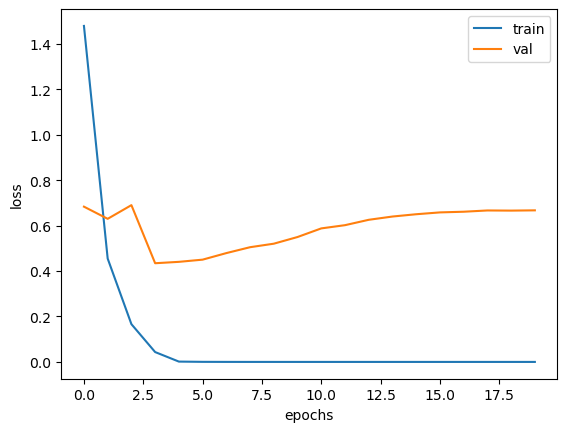

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

In [13]:
output = np.argmax(lstm_model.predict(X_test), axis=1).reshape(-1, 1)
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

4/6 [===================>..........] - ETA: 0s

2022-12-27 18:20:21.207374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-27 18:20:21.246739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 24ms/step


### EEGNet

In [14]:
# Build your model here:
channels = 22
timePoints = 200
F1 = 8
F2 = 16
depth = 2
epochs = 40

eegnet_model = keras.Sequential([
    layers.InputLayer(input_shape=(channels, timePoints)),
    layers.Reshape((channels, timePoints, 1)),
    layers.Conv2D(F1, (1, 64), padding='same', use_bias=False),
    layers.BatchNormalization(axis = 1),
    layers.DepthwiseConv2D((channels, 1), use_bias = False, depth_multiplier = depth, depthwise_constraint = tf.keras.constraints.max_norm(1.)),
    layers.BatchNormalization(axis = 1),
    layers.Activation('elu'),
    layers.AveragePooling2D((1, 4)),
    layers.Dropout(0.25),
    layers.SeparableConv2D(F2, (1, 16), padding='same', use_bias=False),
    layers.BatchNormalization(axis = 1),
    layers.Activation('elu'),
    layers.AveragePooling2D((1, 8)),
    layers.Dropout(0.25),
    layers.Flatten(name = 'flatten'),
    layers.Dense(6, activation='softmax', name='dense', kernel_constraint = tf.keras.constraints.max_norm(.25)),
])

eegnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 22, 200, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 22, 200, 8)        512       
                                                                 
 batch_normalization (BatchN  (None, 22, 200, 8)       88        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 200, 16)       352       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 200, 16)       4         
 hNormalization)                                                 
                                                      

In [15]:
eegnet_model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)
history = eegnet_model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

Epoch 1/40


2022-12-27 18:20:22.008391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 47ms/step - loss: 1.6112 - categorical_accuracy: 0.5033 - val_loss: 1.6509 - val_categorical_accuracy: 0.5987
Epoch 2/40
 1/19 [>.............................] - ETA: 0s - loss: 1.4231 - categorical_accuracy: 0.6250

2022-12-27 18:20:23.143480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 32ms/step - loss: 1.3237 - categorical_accuracy: 0.7053 - val_loss: 1.5577 - val_categorical_accuracy: 0.7566
Epoch 3/40
19/19 [==============================] - 1s 32ms/step - loss: 1.1293 - categorical_accuracy: 0.8113 - val_loss: 1.4059 - val_categorical_accuracy: 0.8026
Epoch 4/40
19/19 [==============================] - 1s 32ms/step - loss: 0.9924 - categorical_accuracy: 0.8510 - val_loss: 1.2853 - val_categorical_accuracy: 0.8684
Epoch 5/40
19/19 [==============================] - 1s 32ms/step - loss: 0.9030 - categorical_accuracy: 0.8692 - val_loss: 1.1741 - val_categorical_accuracy: 0.8882
Epoch 6/40
19/19 [==============================] - 1s 32ms/step - loss: 0.8378 - categorical_accuracy: 0.9007 - val_loss: 1.0728 - val_categorical_accuracy: 0.9013
Epoch 7/40
19/19 [==============================] - 1s 32ms/step - loss: 0.7913 - categorical_accuracy: 0.8990 - val_loss: 0.9717 - val_categorical_accuracy: 0.9079
Epoch 8/40
19/19 [===

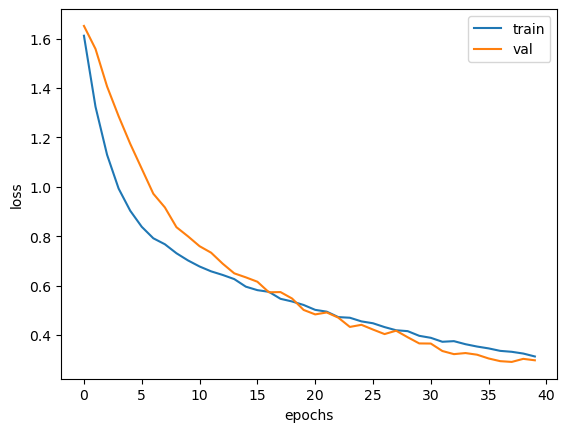

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

In [17]:
output = np.argmax(eegnet_model.predict(X_test), axis=1).reshape(-1, 1)
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 11ms/step


2022-12-27 18:20:47.319214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Model Competition Part

In [18]:
# Build your model here:
channels = 22
timePoints = 200
F1 = 64
F2 = 128
depth = 2
epochs = 40

model = keras.Sequential([
    layers.InputLayer(input_shape=(channels, timePoints)),
    layers.Reshape((channels, timePoints, 1)),
    layers.Conv2D(F1, (1, 64), padding='same', use_bias=False),
    layers.BatchNormalization(axis = 1),
    layers.DepthwiseConv2D((channels, 1), use_bias = False, depth_multiplier = depth, depthwise_constraint = tf.keras.constraints.max_norm(1.)),
    layers.BatchNormalization(axis = 1),
    layers.Activation('elu'),
    layers.AveragePooling2D((1, 4)),
    layers.Dropout(0.25),
    layers.SeparableConv2D(F2, (1, 16), padding='same', use_bias=False),
    layers.BatchNormalization(axis = 1),
    layers.Activation('elu'),
    layers.AveragePooling2D((1, 8)),
    layers.Dropout(0.25),
    layers.Flatten(name = 'flatten'),
    layers.Dense(6, activation='softmax', name='dense', kernel_constraint = tf.keras.constraints.max_norm(.25)),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 22, 200, 1)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 200, 64)       4096      
                                                                 
 batch_normalization_3 (Batc  (None, 22, 200, 64)      88        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 200, 128)      2816      
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 200, 128)      4         
 hNormalization)                                                 
                                                      

In [19]:
model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

Epoch 1/40


2022-12-27 18:20:48.053821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.9266 - categorical_accuracy: 0.7765

2022-12-27 18:20:49.828220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 87ms/step - loss: 0.9266 - categorical_accuracy: 0.7765 - val_loss: 1.6328 - val_categorical_accuracy: 0.9079
Epoch 2/40
19/19 [==============================] - 1s 65ms/step - loss: 0.3417 - categorical_accuracy: 0.9570 - val_loss: 1.5597 - val_categorical_accuracy: 0.8750
Epoch 3/40
19/19 [==============================] - 1s 63ms/step - loss: 0.2425 - categorical_accuracy: 0.9652 - val_loss: 1.4945 - val_categorical_accuracy: 0.9342
Epoch 4/40
19/19 [==============================] - 1s 61ms/step - loss: 0.1860 - categorical_accuracy: 0.9901 - val_loss: 1.4169 - val_categorical_accuracy: 0.9342
Epoch 5/40
19/19 [==============================] - 1s 61ms/step - loss: 0.1699 - categorical_accuracy: 0.9801 - val_loss: 1.3018 - val_categorical_accuracy: 0.9539
Epoch 6/40
19/19 [==============================] - 1s 61ms/step - loss: 0.1454 - categorical_accuracy: 0.9884 - val_loss: 1.2275 - val_categorical_accuracy: 0.9408
Epoch 7/40
19/19 [===

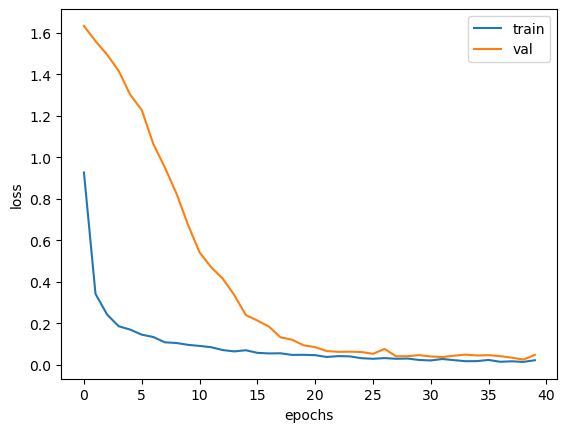

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

In [21]:
output = np.argmax(model.predict(X_test), axis=1).reshape(-1, 1)
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")

5/6 [========================>.....] - ETA: 0s

2022-12-27 18:21:38.283261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 34ms/step
